In [2]:
import numpy as np
from glob import glob
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFile
import torch
import torchvision
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
#load images
dog_files = np.array(glob("dogImages/*/*/*"))
human_files = np.array(glob("lfw/*/*"))

# print number of images in each dataset
print('Total dog images are %d ' % len(dog_files))
print('Total human images are %d ' % len(human_files))

Total dog images are 8351 
Total human images are 13233 


In [7]:
#face detector function
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

def face_detector(img_path):
    
    image = cv2.imread(img_path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #image = Image.open(img_path).convert('L')
    #image = image.convert('L')
    faces = face_cascade.detectMultiScale(image_gray)
    
    return len(faces) > 0


In [19]:
#calculate percentage of human in both files

human_files_per = human_files[:100]
dog_files_per = dog_files[:100]

sum_human_hd = 0
sum_dog_hd = 0

for i in range(0,len(human_files_per)):
    human_hd = human_files_per[i]
    dog_hd = dog_files_per[i]
    
    if face_detector(human_hd) == True:
        sum_human_hd += 1
    if face_detector(dog_hd) == True:
        sum_dog_hd += 1

per_human_hd = (sum_human_hd/len(human_files_per))*100
per_dog_hd = (sum_dog_hd/len(dog_files_per))*100
print("The percentage of human in human files is " ,per_human_hd)
print("The percentage of dog in dog files is " ,per_dog_hd)

The percentage of human in human files is  100.0
The percentage of dog in dog files is  52.0


In [8]:
#percentage of dog in both files
#dog detetctor using vgg16 model

VGG = models.vgg16(pretrained = True)

#VGG function to return index of images from ImageNet
def VGG_16(img):
#def VGG16_predict(img):
    image = Image.open(img)
    data_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])
    image_trans = data_transform(image)
    imagee = image_trans.unsqueeze(0)
    image_var = Variable(imagee)
    image_vgg = VGG(image_var)
    image_index = image_vgg.data.numpy().argmax()
    
    return image_index

In [9]:
#dog detector index b/w 151 and 268
def dog_detector(img):
    index_re = VGG_16(img)
    
    if index_re >= 151 and index_re <= 268:
        return True
    else:
        return False

In [8]:
#calculate percentage of dog in both files
human_files_per = human_files[:100]
dog_files_per = dog_files[:100]

sum_human_dd = 0
sum_dog_dd = 0

for i in range(0,len(human_files_per)):
    human_dd = human_files_per[i]
    dog_dd = dog_files_per[i]
    
   # d = dog_detector(dog_dd)
    
    if dog_detector(human_dd) == True:
        sum_human_dd += 1
    if dog_detector(dog_dd) == True:
        sum_dog_dd += 1

per_human_dd = (sum_human_dd/len(human_files_per))*100
per_dog_dd = (sum_dog_dd/len(dog_files_per))*100
print("The percentage of human in human files is " ,per_human_dd)
print("The percentage of dog in dog files is " ,per_dog_dd)

The percentage of human in human files is  3.0
The percentage of dog in dog files is  93.0


In [10]:
#CNN
#data preperation
data_train = os.path.join("dogImages/","train/")
data_valid = os.path.join("dogImages/","valid/")
data_test = os.path.join("dogImages/","test/")

#transforms

data_transform = { 
                    'train' : transforms.Compose([transforms.RandomResizedCrop(224),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])]),
    
                    'valid' : transforms.Compose([transforms.RandomResizedCrop(224),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])]),
    
                    'test' : transforms.Compose([transforms.RandomResizedCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])
                 }

#load image data set
train_set = datasets.ImageFolder(data_train, transform = data_transform['train'])
valid_set = datasets.ImageFolder(data_valid, transform = data_transform['valid'])
test_set = datasets.ImageFolder(data_test, transform = data_transform['test'])

#Dataloader
batch_size = 10
num_workers = 0
train_loader = torch.utils.data.DataLoader(train_set,batch_size = batch_size,num_workers = num_workers,shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_set,batch_size = batch_size,num_workers = num_workers,shuffle = False)
test_loader = torch.utils.data.DataLoader(test_set,batch_size = batch_size,num_workers = num_workers,shuffle = False)

loaders = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

#check tensor size of the image
sample = next(iter(train_set))
image, label = sample
print(image.shape)

num_classes = train_set.classes
print(len(num_classes))
print(len(loaders['train']))
#print(len(loaders['valid']))
#print(len(loaders['test']))

torch.Size([3, 224, 224])
133
668


In [11]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
#CNN model architecture
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        #convo layers
        self.conv1 = nn.Conv2d(3,32,3)
        self.conv2 = nn.Conv2d(32,64,3)
        self.conv3 = nn.Conv2d(64,128,3)
        self.conv4 = nn.Conv2d(128,256,3)
        self.conv5 = nn.Conv2d(256,512,3)
        
        #pooling layer
        self.pool = nn.MaxPool2d(2,2)
        
        #linear layers
        self.fc1 = nn.Linear(512*5*5,2048)
        self.fc2 = nn.Linear(2048,1024)
        self.fc3 = nn.Linear(1024,133)
         
        #dropout layer
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
    
    def forward(self, x):
        #first layer
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        #second layer
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        #third layer
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout2(x)
        #fourth layer
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        #fifth layer
        x = self.conv5(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)
        #x = self.dropout(x)
        
        #reshape tensor
        x = x.view(-1,512*5*5)
        #last layer
        #x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        x = self.fc3(x)

        return x
         
# instantiate the CNN
net = Net()
print(net)
print(net.modules())
#print(net.conv1.weight.shape)
#print(net.conv1.weight[0][0].shape)
for name,param in net.named_parameters():
    print(name, param.shape)
    #print(param)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12800, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=133, bias=True)
  (dropout1): Dropout(p=0.2)
  (dropout2): Dropout(p=0.3)
)
<generator object Module.modules at 0x10db2fcf0>
conv1.weight torch.Size([32, 3, 3, 3])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 3, 3])
conv2.bias torch.Size([64])
conv3.weight torch.Size([128, 64, 3, 3])
conv3.bias torch.Size([128])
conv4.weight torch.Size([256, 128, 3, 3])
conv4.bias torch.Size([256])
conv5.weight torch.Size(

In [14]:
#loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.05)

#move model to GPU
#use_cuda = torch.cuda.is_available()
#device = torch.device("cuda" if use_cuda else "cpu")

In [52]:
#train and validate model
def train(n_epochs,model,loader,optimizer,criterion,save_path):
    
    for epoch in range(n_epochs):
        train_loss = 0
        valid_loss = 0
        train_loss_1 = 0
        
        #training 
        net.train()
        for batch, (data,target) in enumerate(loaders['train']):
            
            target = target.view(target.size(0),-1)
            #target = Variable(target)
            #print(target.dtype)
            #print(target.size(0))
            target = target.type(torch.FloatTensor)
                
            #print(data.shape)
            #print(target.dtype)
            #print(target.shape)
            #print(target)
            #print(target.item())
 
            #zero the gradients
            optimizer.zero_grad()
            
            #get output
            outputs = net(data)
            #print(outputs.shape)
            #print(outputs.dtype)
            #print(outputs.item())
            
            #calculate loss
            loss = criterion(outputs,target)
            #print(loss.data)
            #print(loss.item())
            #print(loss.grad_fn)
            
            #backward prop
            loss.backward()
            
            #update parameters
            optimizer.step()
            
            #calculate training loss
            #train_loss_1 += loss.item()
            #print(train_loss_1)
            train_loss = train_loss + ((1 / (batch + 1)) * (loss.data - train_loss))
            #print(train_loss)
            
            #print results
            if batch % 100 == 0:
                print("Epoch: {}, Batch: {}, Training Loss: {}".format(epoch+1, batch, train_loss/1000))
        
        #validating
        net.eval()
        for batch, (data,target) in enumerate(loaders['valid']):
            
            target = target.view(target.size(0),-1)
            target = target.type(torch.FloatTensor)
            
            #get output
            outputs = net(data)
            
            #calculate loss
            loss = criterion(outputs,target)

            #calculate training loss
            valid_loss += valid_loss + ((1 / (batch + 1)) * (loss.data - valid_loss))
            
            #print results
            if batch % 100 == 0:
                print(" Validation Loss: {}".format(valid_loss/1000))
            
            '''       
            if valid_loss < valid_loss_min:
                torch.save(model.state_dict(), save_path)
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
                valid_loss_min = valid_loss
            ''' 
            
            #save the model
            torch.save(net.state_dict(), save_path)
            
    #return net       
    print("Finished Training and Validating")

In [53]:
#train the model
n_epochs = 5
train(n_epochs,net,loaders,optimizer,criterion,'saved_model/dog_model.pt')

Epoch: 1, Batch: 0, Training Loss: 1.6380974054336548
Epoch: 1, Batch: 100, Training Loss: 1.4463878870010376
Epoch: 1, Batch: 200, Training Loss: 1.5007566213607788
Epoch: 1, Batch: 300, Training Loss: 1.4978429079055786
Epoch: 1, Batch: 400, Training Loss: 1.485529899597168
Epoch: 1, Batch: 500, Training Loss: 1.486063003540039
Epoch: 1, Batch: 600, Training Loss: 1.4946262836456299
 Validation Loss: 1.0532879829406738
Epoch: 2, Batch: 0, Training Loss: 1.6274768114089966
Epoch: 2, Batch: 100, Training Loss: 1.5443296432495117
Epoch: 2, Batch: 200, Training Loss: 1.4910451173782349
Epoch: 2, Batch: 300, Training Loss: 1.5070194005966187
Epoch: 2, Batch: 400, Training Loss: 1.48008394241333
Epoch: 2, Batch: 500, Training Loss: 1.4766701459884644
Epoch: 2, Batch: 600, Training Loss: 1.4832799434661865
 Validation Loss: 1.0847581624984741
Epoch: 3, Batch: 0, Training Loss: 1.8276785612106323
Epoch: 3, Batch: 100, Training Loss: 1.4394742250442505
Epoch: 3, Batch: 200, Training Loss: 1.4

In [4]:
# load the model that got the best validation accuracy
net.load_state_dict(torch.load('saved_model/dog_model.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [16]:
#test model
def test(loader, model, criterion):

    test_loss = 0
    correct = 0
    total = 0

    for batch, (data, target) in enumerate(loaders['test']):
        target = target.view(target.size(0),-1)
        #target = target.type(torch.FloatTensor)
        # move to GPU
        #if use_cuda:
         #   data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = net(data)
        # calculate the loss
        loss = criterion(output, target.type(torch.FloatTensor))
        #test loss
        test_loss = test_loss + ((1 / (batch + 1)) * (loss.data - test_loss))
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

# call test function    
test(loaders, net, criterion)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10, 133])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 1472.981445


Test Accuracy:  8% (73/836)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([6, 1])) that is different to the input size (torch.Size([6, 133])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [12]:
#to get class names
#for item in loaders['train'].dataset.classes:
class_names = [item[4:].replace("_"," ") for item in loaders['train'].dataset.classes]
#print(class_names)
class_name = [item for item in loaders['valid'].dataset.classes]
print(class_name[54])

#plt.imshow(class_names[52])
#plt.show()

055.Curly-coated_retriever


In [22]:
#dog predictor method to predict the breed
import random
from matplotlib.pyplot import imshow
def predict_dog_breed(img,model,class_name):
    image = Image.open(img).convert('RGB')
    transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])
    image = transform(image)
    test_image = image.unsqueeze(0)
    net.eval()
    output = net(test_image)
    #print(output)
    idx = torch.argmax(output)
    #print(idx)
    #print(class_name[idx])
    a = random.choice(os.listdir("./dogImages/train/{}/".format(class_name[idx])))
    print(a)
    imshow(a)
    #subdir = ''.join(["/dogImages/train/", class_name[idx]])
    #print(file)
    #file = random.choice(os.listdir(subdir))
    #path = ''.join([subdir, file])
    #img = Image.open(path)
    #a = random.choice(os.listdir(file))
    #imshow(a)
    #print(a)
    #a = Image.open("./dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg")
    #a.imshow(np.asarray(a))
    return class_name[idx]

'''
def display_breeds(labels):
    fig = plt.figure(figsize=(16,4))
    for i, label in enumerate(labels):
        print(labels)
        print(label)
        print(i)
        subdir = ''.join(['dog_images/valid/', class_names[idx] + '/'])
        print(subdir)
        file = random.choice(os.listdir(subdir))
        path = ''.join([subdir, file])
        img = Image.open(path)
        ax = fig.add_subplot(1,3,i+1)
        ax.imshow(img, cmap="gray", interpolation='nearest')
        plt.title(label.split('.')[1])
        plt.axis('off')
    plt.show()
'''

'\ndef display_breeds(labels):\n    fig = plt.figure(figsize=(16,4))\n    for i, label in enumerate(labels):\n        print(labels)\n        print(label)\n        print(i)\n        subdir = \'\'.join([\'dog_images/valid/\', class_names[idx] + \'/\'])\n        print(subdir)\n        file = random.choice(os.listdir(subdir))\n        path = \'\'.join([subdir, file])\n        img = Image.open(path)\n        ax = fig.add_subplot(1,3,i+1)\n        ax.imshow(img, cmap="gray", interpolation=\'nearest\')\n        plt.title(label.split(\'.\')[1])\n        plt.axis(\'off\')\n    plt.show()\n'

In [23]:
#identify between human and dog and thus predict corresponding breed
def dog_or_human(img):
    image = Image.open(img)
    plt.imshow(image)
    plt.show()
    if dog_detector(img) == True:
        predict_dog = predict_dog_breed(img, net, class_name)
        print("Dog Detected!The breed is {}".format(predict_dog))
    elif face_detector(img) > 0:
        predict_human = predict_dog_breed(img, net, class_name)
       # display_breeds(class_name)
        print("Human Detected!You look like {}".format(predict_human))
        #print(class_names[idx])
    else:
        print("Neither human or dog detected!")

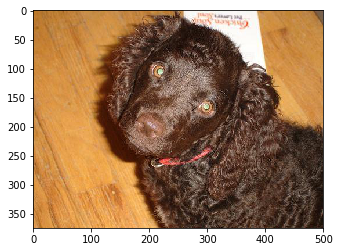

American_foxhound_00504.jpg


TypeError: Image data cannot be converted to float

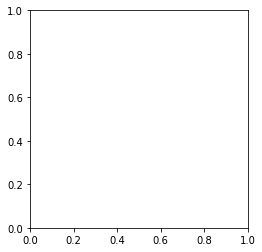

In [24]:
for img_file in os.listdir('./images'):
    image = os.path.join('./images', img_file)
    dog_or_human(image)